In [82]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

# Plant

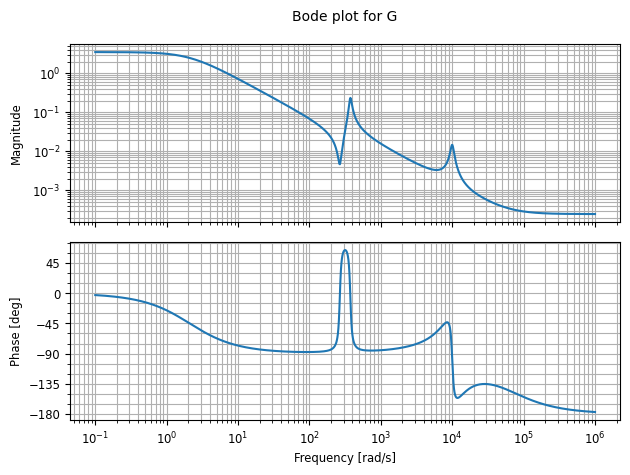

In [83]:

Gf = tf_from_txt(r'tf_txt\Gf.txt')
Gf.name = 'G'
ctrl.bode(Gf)

In [84]:
Gf

TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# Model error (Multiplicatibly uncertainty)

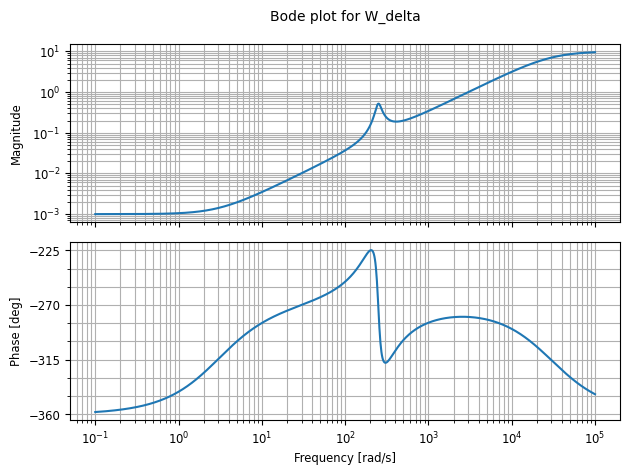

In [85]:
W_delta = tf_from_txt(r'tf_txt\W_delta.txt')
W_delta.name = 'W_delta'
ctrl.bode(W_delta)

# Controller from AST

In [86]:
print(ast.speed_ctrl_params)

speed_ctrl = ast.speed_ctrl_params

C = speed_ctrl.Kp*(1 + 1/(s*speed_ctrl.Ti))

assert len(speed_ctrl.act_value_filters) == 0

F = 1 

print("Torque setpoint filters: ")

for filt in speed_ctrl.current_setp_filters:
    print(filt)
    if isinstance(filt,tt.tracetypes.PT2):
        pt2i = tt.sinu_tf.PT2(filt.freq,filt.damping)
        F *= pt2i
    elif isinstance(filt,tt.tracetypes.SecondOrdFilter):
        pt2i = tt.sinu_tf.PT2(filt.den_f,filt.den_d) / tt.sinu_tf.PT2(filt.num_f,filt.num_d)
        F *= pt2i
    else:
        raise Exception('Only PT2 filter supported for now..')
    

C_ast = C*F
C_ast.name = 'C_ast'
C_ast

SpeedCtrl(Kp=22.242147839669272, Ti=0.035, Ts=0.00025, ref_mdl_active=True, ref_mdl_freq=37.567485311159444, ref_mdl_d=0.7071, ref_mdl_delay=0.0, act_value_filters=[], current_setp_filters=[PT2(freq=2000.0, damping=0.7071), SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)])
Torque setpoint filters: 
PT2(freq=2000.0, damping=0.7071)
SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)


TransferFunction(array([1.18949441e+16, 2.42472757e+19, 1.15164330e+24, 3.28845779e+25]), array([3.38661599e+06, 7.68413211e+10, 1.15849295e+15, 8.45380258e+18,
       5.17468113e+22, 0.00000000e+00]))

# Import Hinf controller

In [87]:


lines = []
with open(r'tf_txt/C_hinf.txt','r') as f:
    lines = f.readlines()
lines

lines = [x.strip().replace('[','').replace(']','') for x in lines]
    

num = [float(x) for x in lines[0].split(',')]
den = [float(x) for x in lines[1].split(',')]

num = np.array(num)
den = np.array(den)

num =  np.flip(num)
den = np.flip(den)

C_hinf = ctrl.tf(num,den)
C_hinf.name = 'C_Hinf'

C_hinf

TransferFunction(array([8.30181226e+04, 3.11713480e+09, 2.81744572e+13, 3.36448756e+17,
       1.70791396e+21, 1.63105284e+24, 7.90546064e+26, 3.34549259e+29,
       9.55813547e+31, 1.53511508e+34, 3.01096510e+36, 6.24900288e+36]), array([1.00000000e+00, 4.36789983e+04, 5.59011373e+08, 6.06598627e+12,
       3.49752210e+16, 8.15399410e+19, 6.25529920e+22, 2.49561126e+25,
       8.37956669e+27, 2.12661907e+30, 2.90688617e+32, 5.37718190e+34,
       2.36035039e+34]))

# Import IMC Controller

In [88]:

C_imc = tf_from_txt(r'tf_txt\C_imc.txt')
C_imc.name = 'C_IMC'
C_imc

TransferFunction(array([6.82038536e+03, 7.04452409e+06, 6.83216846e+11, 2.33700415e+13,
       9.54189631e+16, 2.00050115e+17]), array([1.00000000e+00, 1.06521622e+04, 1.06606536e+08, 6.61100576e+10,
       8.93834433e+12, 4.46970502e+15, 0.00000000e+00]))

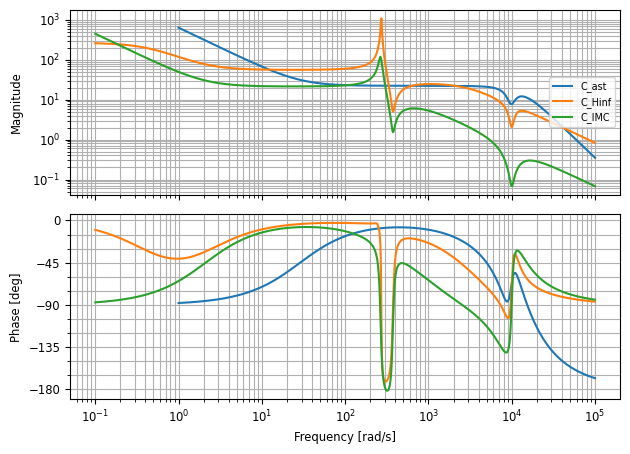

In [89]:
ctrl.bode(C_ast)
ctrl.bode(C_hinf)
ctrl.bode(C_imc)

# Open loop and stability margins

0 states have been removed from the model
5 states have been removed from the model
9 states have been removed from the model


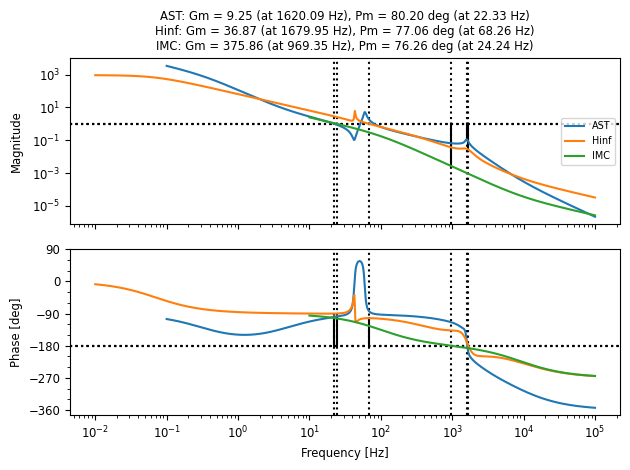

In [90]:

L = Gf*C_ast
L = ctrl.minreal(L)
L.name = 'AST'

Lh = C_hinf*Gf
Lh = ctrl.minreal(Lh)
Lh.name = 'Hinf'

L_imc = Gf*C_imc
L_imc = ctrl.minreal(L_imc)
L_imc.name = 'IMC'



ctrl.bode(L,display_margins=True,Hz=True)   

#plt.figure()

ctrl.bode(Lh,display_margins=True,Hz=True)

#plt.figure()

ctrl.bode(L_imc,display_margins=True,Hz=True)


# Sensitivity

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
S_peak_ast: 1.125638103451396
S_peak_hinf: 1.0828542126870502
S_peak_imc: 1.1567558028953684


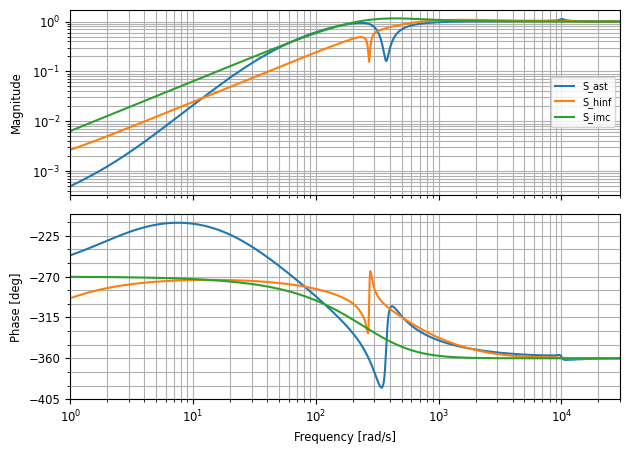

In [91]:

S_ast = 1/(1+L)
S_ast = ctrl.minreal(S_ast)
S_ast.name = 'S_ast'

S_hinf = 1/(1+Lh)
S_hinf = ctrl.minreal(S_hinf)
S_hinf.name = 'S_hinf'

S_imc = 1/(1+L_imc)
S_imc = ctrl.minreal(S_imc)
S_imc.name = 'S_imc'


omega_limits = [1,3*1e4]

ctrl.bode(S_ast,omega_limits=omega_limits)
ctrl.bode(S_hinf,omega_limits=omega_limits)
ctrl.bode(S_imc,omega_limits=omega_limits)


def peak_norm(G):

    Y = ctrl.frequency_response(G).response[0][0]
    return np.max(np.abs(Y))


S_peak_ast = peak_norm(S_ast)
S_peak_hinf = peak_norm(S_hinf)
S_peak_imc = peak_norm(S_imc)

print(f'S_peak_ast: {S_peak_ast}')
print(f'S_peak_hinf: {S_peak_hinf}')
print(f'S_peak_imc: {S_peak_imc}')


# Robust stability

Condition for robust stability

$$
|T(s)W_\Delta(s)| < 1
$$


10 states have been removed from the model
15 states have been removed from the model
2 states have been removed from the model
T_rob_ast_peak: 0.4045491030655135
T_rob_hinf_peak: 0.3848361284841518
T_rob_imc_peak: 0.3189554461539275


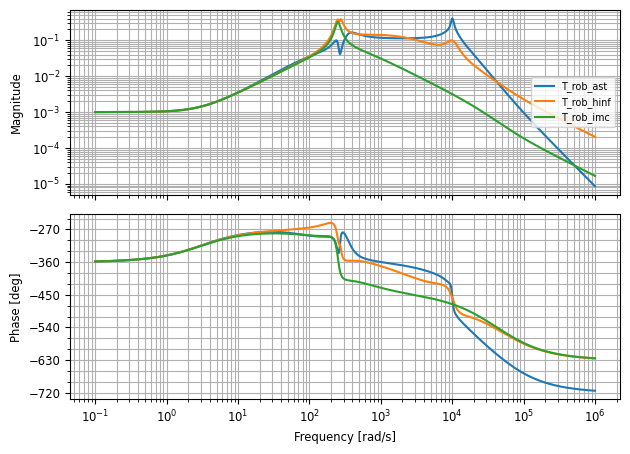

In [92]:

T_rob_ast = L*S_ast*W_delta
T_rob_ast = ctrl.minreal(T_rob_ast)
T_rob_ast.name = 'T_rob_ast'

T_rob_hinf = Lh*S_hinf*W_delta
T_rob_hinf = ctrl.minreal(T_rob_hinf)
T_rob_hinf.name = 'T_rob_hinf'

T_rob_imc = L_imc*S_imc*W_delta
T_rob_imc = ctrl.minreal(T_rob_imc)
T_rob_imc.name = 'T_rob_imc'

ctrl.bode(T_rob_ast)
ctrl.bode(T_rob_hinf)
ctrl.bode(T_rob_imc)

T_rob_ast_peak = peak_norm(T_rob_ast)
T_rob_hinf_peak = peak_norm(T_rob_hinf)
T_rob_imc_peak = peak_norm(T_rob_imc)

print(f'T_rob_ast_peak: {T_rob_ast_peak}')
print(f'T_rob_hinf_peak: {T_rob_hinf_peak}')
print(f'T_rob_imc_peak: {T_rob_imc_peak}')


# Closed loop

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


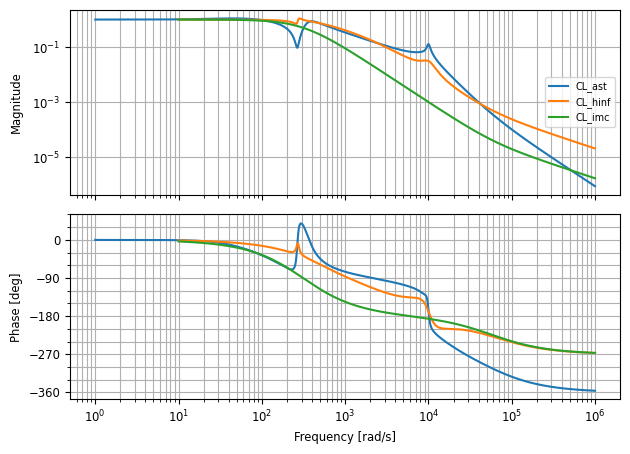

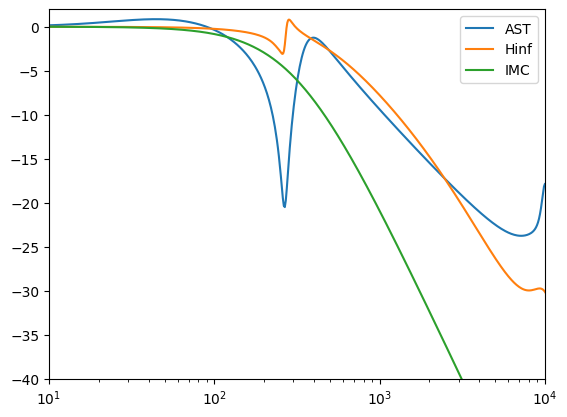

In [93]:

CL_ast = ctrl.feedback(L)
CL_ast = ctrl.minreal(CL_ast)
CL_ast.name = 'CL_ast'

CL_hinf = ctrl.feedback(Lh)
CL_hinf = ctrl.minreal(CL_hinf)
CL_hinf.name = 'CL_hinf'

CL_imc = ctrl.feedback(L_imc)
CL_imc = ctrl.minreal(CL_imc)
CL_imc.name = 'CL_imc'

ctrl.bode(CL_ast)
ctrl.bode(CL_hinf)
ctrl.bode(CL_imc)


plt.figure()
plot_mag(CL_ast)
plot_mag(CL_hinf,)
plot_mag(CL_imc)
plt.xlim([10,1e4])
plt.ylim([-40,2])
plt.legend(['AST','Hinf','IMC'])


(-0.07, 0.2)

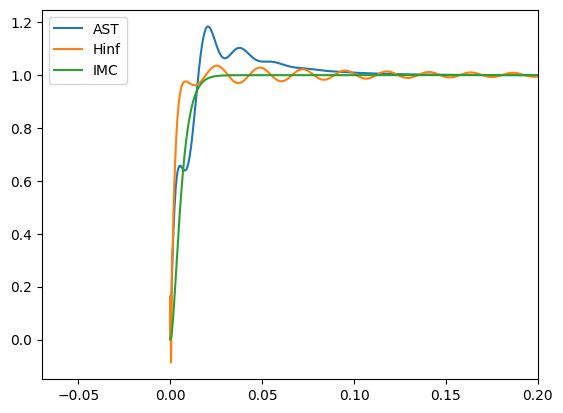

In [94]:

t = np.linspace(0,0.4,100000)
t0, y0 = ctrl.step_response(CL_ast,T=t)
t1, y1 = ctrl.step_response(CL_hinf,T=t)
t2, y2 = ctrl.step_response(CL_imc,T=t)

plt.plot(t0,y0)
plt.plot(t1,y1)
plt.plot(t2,y2)

plt.legend(['AST','Hinf','IMC'])
plt.xlim([-0.07,0.2])
